# Hallar la gráfica de potencia vs probabilidad de aparición

- Capturar señales. x
- Clasificar señales entre presencia y no presencia. x
- Estimar psd welch por cada señal por cada tipo. x
- Potencia promedio de cada señal con un ancho de banda del 90% Hacer vector.
- Construir histograma por cada tipo. Usar kde.
- Definir media y varianza por cada tipo.
- Definr umbral como el punto de intersección entre las gaussianas, o si no es el caso, el promedio de la media de cada gaussiana.

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sig
from sklearn.preprocessing import MinMaxScaler

In [19]:
def audio_matrix(path, scaler):
    fs_v = []
    audio_m = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        
        
        y, sr = librosa.load(file_path, sr=None)
        y = librosa.to_mono(y)
        y = y.reshape(-1, 1)
        y = scaler.fit_transform(y)
        y = y.flatten()
        
        fs_v.append(sr)
        audio_m.append(y)

    # Calcular la frecuencia de muestreo promedio
    fs = np.mean(fs_v)

    # Asegurarse de que todos los arreglos de audio tengan la misma longitud
    max_length = max(len(y) for y in audio_m)
    audio_m_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_m])

    return audio_m_padded, fs

def welch_vector(X, fs, window, nperseg, nfft):
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def psd_matrix(audio_m,  fs, window):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    psd_matrix = np.zeros((M,N))          
    for i in range(M):
        audio_v = audio_m[i]
        f, psd = welch_vector(audio_v, fs,  window, (N-1), (N*2)-1)
        psd_matrix[i] = psd
    return f, psd_matrix

def audio_classif(classif,  audio_m):
    N = audio_m.shape[1]

    one_count = np.sum(classif)
    zero_count = len(classif) - one_count

    audio_one_m = np.zeros((one_count, N))
    audio_zero_m = np.zeros((zero_count, N))

    audio_one_m = audio_m[classif == 1]
    audio_zero_m = audio_m[classif == 0]

    return  audio_one_m, audio_zero_m

In [20]:
path = r'C:\Audio_fm'
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_m, fs = audio_matrix(path, scaler)

df = pd.read_excel('audio_fm_classification.xlsx')
df.head()

,audio_names,Classification
0,100.0_0_.wav,0
1,100.0_1_.wav,0
2,100.0_2_.wav,0
3,100.0_3_.wav,1
4,100.0_4_.wav,0


In [21]:
t = np.linspace(0, audio_m.shape[1]/fs, num=audio_m.shape[1])

classif = df['Classification'].to_numpy()

audio_ones, audio_zeros = audio_classif(classif, audio_m)

In [22]:
f, psd_ones = psd_matrix(audio_ones, fs,  'blackmanharris')
f, psd_zeros = psd_matrix(audio_zeros, fs,  'blackmanharris')


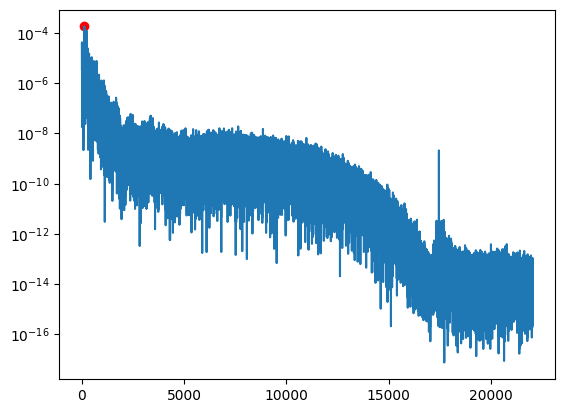

In [29]:
psd_sample = psd_ones[100]

max_idx = np.argmax(psd_sample)
freq_max = f[max_idx]
max_point = psd_sample[max_idx]

plt.semilogy(f, psd_sample)
plt.scatter(freq_max, max_point, color='red')
plt.show()